# Tumblr Python Tag Topic Analysis

There are many ways in how to analyse the topics of different texts. The methods include things like word clouds, network analysis of tags, TF-IDF, and algorithms, that exist for this problem class, like LSA, LDA and many more. 

## Imports

In [231]:
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import pyLDAvis.gensim
import collections
import statistics
import networkx
import pyLDAvis
import string
import gensim
import pickle
import shutil
import pandas
import json
import nltk
import os

In [88]:
pyLDAvis.enable_notebook()

## Download Data

I wrote the script, to download all the posts with the specific tag and save it in the folder. The script can be found also in this repository. It is the DownloadTumblirData.py file. The usage is explaned in the script. 

## Constants

Here I am first defining the folder, where different saved data is going to be hold. The folder_post is the folder, where the posts were loaded with the script. The folder_text_data is where the text of the posts is going to be saved. And the folder_preprocessed is where the preprocessed text is going to be saved (since preprocessing takes some time). The filtered folder is the folder, after the filtering based on corpus is done. 

The folder_model and folder_vis are folder, where the models and visualizations are going to be saved. The 1 is meant for the modeling, that is going to distigush the use of tag python between the python as programming langauge and python as everything else.

In [497]:
folder_posts = "data"
folder_text_data = "posts_text"
folder_preprocessed = "preprocessed"
folder_filtered = "filtered_text"
folder_python = "text_python"
folder_models_1 = "models_1"
folder_vis_1 = "vis_1"
folder_models_2 = "models_2"
folder_vis_2 = "vis_2"
folder_coding = "text_coding"
folder_models_3 = "models_3"
folder_vis_3 = "vis_3"

## Tag Analysis

In order to see, if there are any group, I am first going to analyze the tags in the posts. I will try to see, if there are any tags that appear together more frequently than it would be expected from their seperate frequencies.

First I will analyze the posts, to see extract the tags from them.

In [34]:
all_posts = os.listdir(folder_posts)

In [35]:
number_of_files = len(all_posts)

In [36]:
all_tags = []
all_tags_connections = collections.defaultdict(dict)

In [37]:
for filename in all_posts:
    with open(os.path.join(folder_posts, filename), "r") as f:
        data = f.readlines()
        data = " ".join(data)
    data = json.loads(data)
    current_tags = data["tags"]
    current_tags = [t.lower() for t in current_tags]
    for tag1 in current_tags:
        for tag2 in current_tags:
            if tag1 > tag2:
                try:
                    all_tags_connections[tag1][tag2] += 1
                except KeyError:
                    all_tags_connections[tag1][tag2] = 1
    all_tags += current_tags

In [38]:
all_tags_count = collections.Counter(all_tags)

In [39]:
all_tags_freq = {k: v / number_of_files for k, v in all_tags_count.items()}

In [40]:
all_tags_count.most_common(20)

[('python', 40610),
 ('learn python', 14504),
 ('python tutorial', 13952),
 ('python programming', 13582),
 ('python development', 12729),
 ('programming', 4075),
 ('automatically generated text', 3792),
 ('patrick mooney', 3791),
 ('markov chains', 3764),
 ('snake', 3292),
 ('paul graham', 2394),
 ('development', 1963),
 ('coding', 1721),
 ('machine learning', 1624),
 ('ball python', 1523),
 ('python3', 1394),
 ('software development', 1375),
 ('reptiblr', 1365),
 ('expert', 1324),
 ('engineering', 1315)]

Up above one can see the most frequent tags. Since these are the posts, that always have to include the python tag, it is not surprising, that it dominates. But one can also see, which tags frequently appear with this tag.

Next, I am going to create a graph, where the edges will be the difference between the expected and observed frequency of connection. The expected frequency is the multiplication of the frequencies, with which the tags appear in the database. The obesrved frequency will then have the expected one removed from it. If the resulting value is more than 0, then the connection appear more than expected. If it is negative, then it appears less then expected. 

In [43]:
T=networkx.Graph()

In [44]:
for tag1, data in all_tags_connections.items():
    for tag2, count in data.items():
        freq_con = count / number_of_files
        freq_expect = all_tags_freq[tag1] * all_tags_freq[tag2]
        surprise = freq_con - freq_expect
        if surprise > 0.02:
            T.add_edge(tag1,tag2,weight=surprise)

In [45]:
len(T.nodes())

28

/usr/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


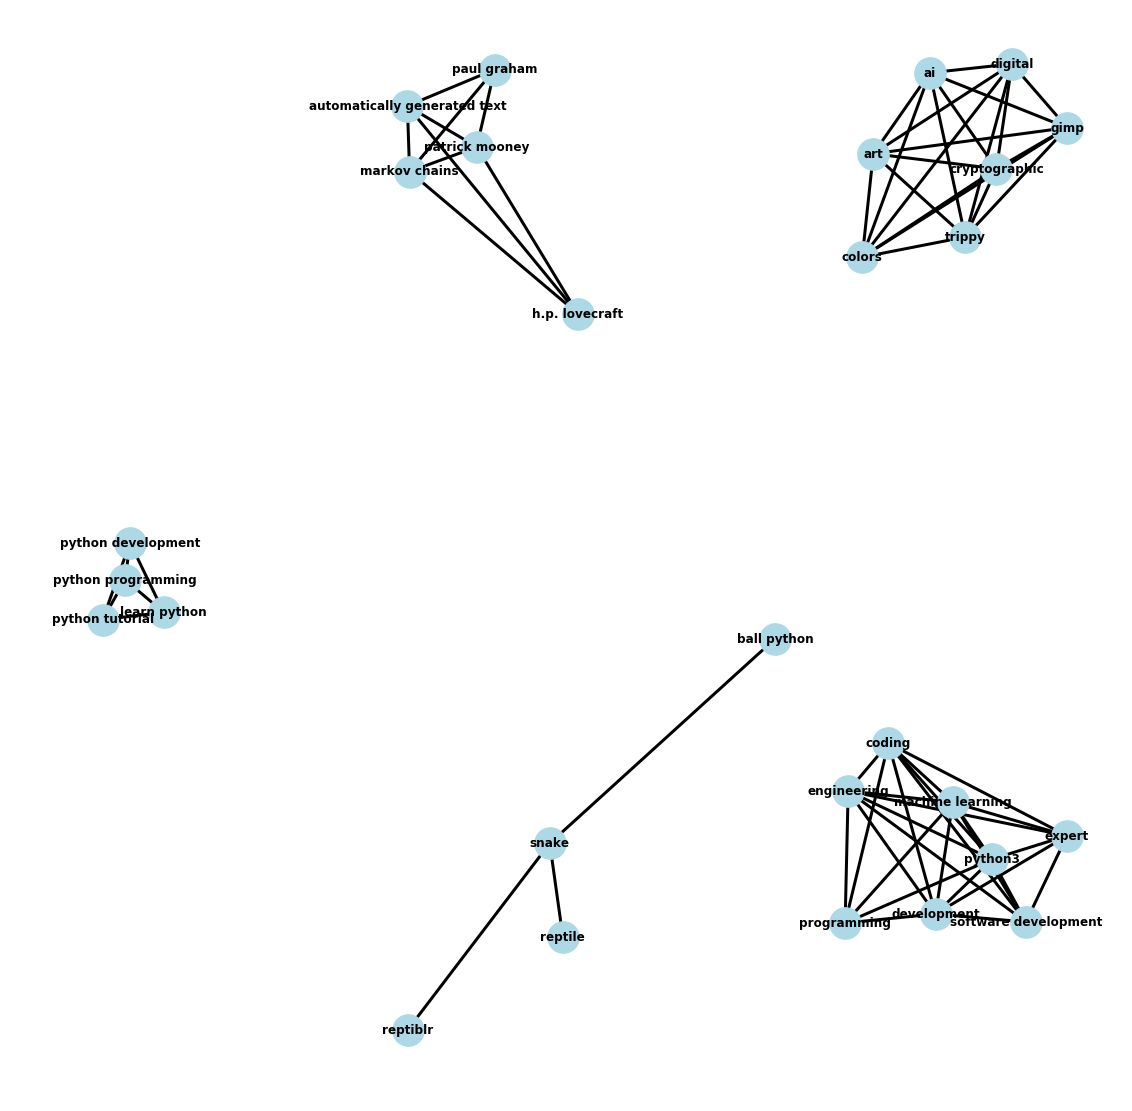

In [48]:
plt.figure(1,figsize=(15,15)) 
networkx.draw(T, 
        with_labels=True, 
        pos=networkx.spring_layout(T), 
        font_weight='bold', 
        node_color="lightblue",
        width=3, 
        arrows=True, 
        node_size=1000,
             )

As it can been seen from the picture, there are groups of tags that appear together more than expected. There is the snake group, python learning group, pything development, art and artificial intelligence and whatever the fuck the last one is. 

## Topic Analysis - Preprocessing

First I need to get all the posts, that were downloaded and take the text from the posts. 

In [7]:
all_posts = os.listdir(folder_posts)

In [8]:
all_types = []
for post in all_posts:
    with open(os.path.join(folder_posts, post), "r") as f:
        data = f.readlines()
        data = " ".join(data)
    data = json.loads(data)
    all_types.append(data["type"])

In [9]:
collections.Counter(all_types).most_common()

[('photo', 24143),
 ('text', 12059),
 ('link', 2803),
 ('video', 1181),
 ('quote', 148),
 ('answer', 144),
 ('audio', 34),
 ('chat', 33)]

I am interested in the ones, that have text, which would be text, link, quote, answer and chat. 

If one takes the look in the distribution of the posts, it can be seen that some are a lot more popular than others. The photo and text have an order of magnitude more posts than the rest of them. Since the article that I read showed some problems with potentially short posts (Comparing Topic Models for a Movie Recommendation System by Sonia Bergamaschi, Laura Po and Serena Sorrentino), and that text and answers are usually the longer ones (from my preception of reading a subset of them), I decided to use just the text one (there were not a lot of answers, so I eliminated these). 

In order to prove my intuition, I also checked the length of it.

In [10]:
all_lengths = collections.defaultdict(list)
for post in all_posts:
    with open(os.path.join(folder_posts, post), "r") as f:
        data = f.readlines()
        data = " ".join(data)
        data = json.loads(data)
    if data["type"] == "text":
        all_lengths["text"].append(len(data["body"]))
    if data["type"] == "link":
        all_lengths["link"].append(len(data["description"]))
    if data["type"] == "quote":
        all_lengths["quote"].append(len(data["text"]))
    if data["type"] == "answer":
        all_lengths["answer"].append(len(data["answer"]))
    if data["type"] == "chat":
        all_lengths["chat"].append(len(data["body"]))

In [13]:
for post_type, lengths in all_lengths.items():
    print(post_type, statistics.mean(lengths))

text 3251.14230035658
link 293.61077417053156
quote 332.97297297297297
answer 1093.6597222222222
chat 338.09090909090907


My intuition ended up being right. Comparing the mean length (based on characters), the link, quote and chat are quite shorter than answer, which is again shorter than text. So I am onyl going to be using text posts in my analysis. 

In [20]:
for post in all_posts:
    with open(os.path.join(folder_posts, post), "r") as f:
        data = f.readlines()
        data = " ".join(data)
    data = json.loads(data)
    text = ""
    if data["type"] == "text":
        title = data["title"]
        if title:
            title = BeautifulSoup(title)
            title = title.get_text()
            text += title
            text += " "
        body = data["body"]
        if body:
            body = BeautifulSoup(body)
            body = body.get_text()
            text += body
    if text:
        with open(os.path.join(folder_text_data, post), "w") as f:
            f.write(text)

/usr/lib/python3.7/site-packages/bs4/__init__.py:335: UserWarning: "http://docopt.org/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Next I am going to put the text through some preprocessing. I will tokenize all of the text posts. Then I will remove all the words with 1 or 2 characters, all stop words, and punctuation. Then I will only keep the nouns, verbs, adjectives and adverbs. After that I will lemmatize and stem the words. Then I will create the bi- and three-grams, and keep the ones, where all the words above will survive the filtering process. 

In [26]:
stop_words = set(nltk.corpus.stopwords.words("english"))
lem = nltk.stem.WordNetLemmatizer()
stem = nltk.stem.porter.PorterStemmer()

In [27]:
all_text_posts = os.listdir(folder_text_data)

In [31]:
for post in all_text_posts:
    with open(os.path.join(folder_text_data, post), "r") as f:
        data = f.readlines()
        data = " ".join(data)
    data = data.lower()
    data_words = nltk.tokenize.word_tokenize(data)
    data_words = [w.strip() for w in data_words if w.strip()]
    data_words_filtered = [w for w in data_words if w not in stop_words and w not in string.punctuation and w not in "`’”“"]
    data_words_filtered = [w for w in data_words_filtered if len(w) > 2]
    data_words_filtered = [w for w in data_words_filtered if nltk.pos_tag([w])[0][1][:2] in {"JJ", "NN", "VB", "RB"}]
    data_words_filtered = [lem.lemmatize(w) for w in data_words_filtered]
    data_words_filtered = [stem.stem(w) for w in data_words_filtered]
    data_bigrams = nltk.bigrams(data_words)
    data_bigrams = [(w1, w2) for w1, w2 in data_bigrams if len(w1) > 2 and len(w2) > 2]
    data_bigrams = [(w1, w2) for w1, w2 in data_bigrams if w1 not in stop_words and w2 not in stop_words]
    data_bigrams = [(w1, w2) for w1, w2 in data_bigrams if w1 not in string.punctuation and  w2 not in string.punctuation]
    data_bigrams = [(w1, w2) for w1, w2 in data_bigrams if w1 not in "`’”“" and w2 not in "`’”“"]
    data_bigrams = [(w1, w2) for w1, w2 in data_bigrams if nltk.pos_tag([w1])[0][1][:2] in {"JJ", "NN", "VB", "RB"} and nltk.pos_tag([w2])[0][1][:2] in {"JJ", "NN", "VB", "RB"}]
    data_bigrams = [(lem.lemmatize(w1), lem.lemmatize(w2)) for w1, w2 in data_bigrams]
    data_bigrams = [(stem.stem(w1), stem.stem(w2)) for w1, w2 in data_bigrams]
    data_bigrams = [" ".join([w1, w2]) for w1, w2 in data_bigrams]
    data_trigrams = nltk.ngrams(data_words, 3)
    data_trigrams = [(w1, w2, w3) for w1, w2, w3 in data_trigrams if len(w1) > 2 and len(w2) > 2 and len(w3) > 2]
    data_trigrams = [(w1, w2, w3) for w1, w2, w3 in data_trigrams if w1 not in stop_words and w2 not in stop_words and w3 not in stop_words]
    data_trigrams = [(w1, w2, w3) for w1, w2, w3 in data_trigrams if w1 not in string.punctuation and  w2 not in string.punctuation and w3 not in string.punctuation]
    data_trigrams = [(w1, w2, w3) for w1, w2, w3 in data_trigrams if w1 not in "`’”“" and w2 not in "`’”“" and w3 not in "`’”“"]
    data_trigrams = [(w1, w2, w3) for w1, w2, w3 in data_trigrams if nltk.pos_tag([w1])[0][1][:2] in {"JJ", "NN", "VB", "RB"} and nltk.pos_tag([w2])[0][1][:2] in {"JJ", "NN", "VB", "RB"} and nltk.pos_tag([w3])[0][1][:2] in {"JJ", "NN", "VB", "RB"}]
    data_trigrams = [(lem.lemmatize(w1), lem.lemmatize(w2), lem.lemmatize(w3)) for w1, w2, w3 in data_trigrams]
    data_trigrams = [(stem.stem(w1), stem.stem(w2), stem.stem(w3)) for w1, w2, w3 in data_trigrams]
    data_trigrams = [" ".join([w1, w2, w3]) for w1, w2, w3 in data_trigrams]
    data_words_filtered += data_bigrams
    data_words_filtered += data_trigrams
    if len(data_words_filtered) > 20:
        with open(os.path.join(folder_preprocessed, post), "w") as f:
            for w in data_words_filtered:
                f.write(w + "\n")

Next I am going to filter the most frequent and least frequent words out. I am going to filter all the words, that appear in less than 0,5% of posts and words that appear in more than 90% of posts. 

I am going to do this, because when I was analysing the MeiCogSci abstracts, I got a lot better results, when I removed all the words, that appear in more than half of the posts. Since here I think some of the more frequent words can still tell quite a lot about the topic, I put in a more lenent threshold. 

In [49]:
number_of_posts = len(os.listdir(folder_preprocessed))

In [50]:
all_preprocessed_posts = os.listdir(folder_preprocessed)

In [51]:
all_words_in_texts = []
for filename in all_preprocessed_posts:
    with open(os.path.join(folder_preprocessed, filename), "r") as f:
        words = f.readlines()
        words = [w.strip() for w in words]
    all_words_in_texts += list(set(words))

In [52]:
all_words_in_texts_freq = collections.Counter(all_words_in_texts)

In [53]:
keep = set()

In [54]:
for word, count in all_words_in_texts_freq.items():
    freq = count/number_of_posts
    if freq < 0.9 and freq > 0.005:
        keep.add(word)

In [55]:
keep = set([w.strip() for w in keep if w.strip()])

In [58]:
all_texts = []
for filename in all_preprocessed_posts:
    with open(os.path.join(folder_preprocessed, filename), "r") as f:
        words = f.readlines()
        words = [w.strip() for w in words if w.strip() in keep]
    if len(words) > 20:
        all_texts.append(words)
        with open(os.path.join(folder_filtered, filename), "w") as f:
            for w in words:
                f.write(w + "\n")

In [59]:
len(os.listdir(folder_filtered))

8116

So now I have the filtered posts, the ones that are long enough to be able to used them for analysis and all preprocessed. I am now left with 8116 posts, to try and extract the topics from them.

## Topic Modeling - Modeling (What Python is Meant?)

Here I am still dealing with all the posts, that had python as the tag. As seen above, some of the posts are clearly snake related, which is something that I don't want in my dataset. I want posts that talk about python as a programming langauges. Lets see if topic modeling can help distinguist these posts?

First I need to put the texts into a form, that can be used by the modeling libary. 

In [63]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [64]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in all_texts]

Now I need to create the models to help me with filtering out the non-programming python posts. I think the 5 topics will be enough for this, so I am going to generate the model for number of topics from 2 to 5 and save them to file.

In [83]:
models = []

In [84]:
for i in range(2,6):
    print(i)
    name = "LDA_1_" + str(i)
    Lda = gensim.models.ldamodel.LdaModel
    model = Lda(doc_term_matrix, num_topics=i, id2word = dictionary, passes=20)
    model.save(os.path.join(folder_models_1, name))
    vis = pyLDAvis.gensim.prepare(model, doc_term_matrix, dictionary)
    with open(os.path.join(folder_vis_1, name), "wb") as f:
        pickle.dump(vis, f)
    pyLDAvis.save_html(vis, os.path.join(folder_vis_1, name + ".html"))
    models.append([i, model, vis])

2


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


3


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


4


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


5


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


By inspecting the vizualization created by pyLDAvis.prepare() and saved by the pyLDAvis.save_html() function, there are two topics, that could help with filtering the non-programming topics out. This are the two-topic solution and the three-topic solution. I have printed out the most descriptive words for each topic, along with their weights. 

In [94]:
models[0][1].print_topics(num_topics=-1, num_words=15)

[(0,
  '0.007*"use" + 0.007*"get" + 0.007*"peopl" + 0.007*"startup" + 0.007*"work" + 0.006*"make" + 0.006*"thing" + 0.005*"python" + 0.005*"want" + 0.005*"time" + 0.004*"think" + 0.004*"way" + 0.004*"good" + 0.004*"start" + 0.004*"compani"'),
 (1,
  '0.008*"god" + 0.006*"old" + 0.006*"night" + 0.006*"moon" + 0.005*"man" + 0.004*"strang" + 0.004*"earth" + 0.004*"stone" + 0.004*"thing" + 0.004*"citi" + 0.004*"atal" + 0.004*"dark" + 0.004*"saw" + 0.004*"cat" + 0.004*"light"')]

The two topic solution seems to create the solution of programming jobs and nature. 

* The **PROGRAMMING JOBS** topic have words like use, get, people, startup, work, make, thing, python, want, time and think
* The **NATURE** topic have words like god, old, night, moon, man, strange, earth, stone, thing, cuty, dark, saw, cat and light

In [96]:
models[1][1].print_topics(num_topics=-1, num_words=15)

[(0,
  '0.015*"python" + 0.012*"use" + 0.008*"code" + 0.006*"print" + 0.006*"return" + 0.006*"import" + 0.005*"file" + 0.005*"creat" + 0.005*"twilio" + 0.005*"number" + 0.005*"link" + 0.005*"new" + 0.005*"time" + 0.005*"def" + 0.005*"data"'),
 (1,
  '0.009*"peopl" + 0.009*"startup" + 0.008*"thing" + 0.007*"work" + 0.007*"get" + 0.007*"make" + 0.006*"good" + 0.005*"want" + 0.005*"think" + 0.005*"compani" + 0.005*"way" + 0.005*"seem" + 0.004*"much" + 0.004*"someth" + 0.004*"even"'),
 (2,
  '0.011*"god" + 0.007*"man" + 0.007*"moon" + 0.007*"old" + 0.007*"night" + 0.006*"earth" + 0.006*"strang" + 0.006*"stone" + 0.005*"atal" + 0.005*"men" + 0.005*"dark" + 0.005*"barzai" + 0.005*"light" + 0.004*"valley" + 0.004*"daemon"')]

The three topic solution sees to create the topics of programming, jobs and nature.

* The **PROGRAMMING** topic have words like python, use, code, print, return, import, file, create, number, link, new, time, def and data
* The **JOB** topic have words like people, startup, thing, work, get, make, good, want, think, company, way, seem, much and something
* The **NATURE** topic have words like god, man, moon, old, night, earth, strange, stone, men, dark, light, valley and daemon

By going through both of them, I decided that I am simply going to remove the posts, where the topic of nature is the strongest one, using the three-topic solution. I will keep the rest of the posts.

In order to do this, I will first go through all the posts and see which of the topics is the most highly represented. 

In [133]:
all_files_filtered = os.listdir(folder_filtered)

In [134]:
topics_of_files = []
m = models[1][1]
model_name = "model_1_3"
for filename in all_files_filtered:
    text_name = filename
    with open(os.path.join(folder_filtered, filename)) as f:
        data_file = f.readlines()
    data_file = [w.strip() for w in data_file]
    new_vector = dictionary.doc2bow(data_file)
    topics_current = m.get_document_topics(new_vector)
    topics_of_files.append(tuple([model_name, text_name, topics_current]))

In [136]:
topics_of_files2 = [(filename, [t for t, v in topics if v == max([v for t, v in topics])][0]) for model_name, filename, topics in topics_of_files]

In [137]:
collections.Counter([t for f, t in topics_of_files2])

Counter({1: 3509, 2: 745, 0: 3862})

Here we can see the number of files, by the strongest topic in that text. The nature one seems to be the least frequent, where it is present in less than 1000 texts. The other two topics (programming and jobs) are the strongest topic in between 3000-4000 texts. 

I am also interested in how many files actually have any of the nature topic included. So this is also something, that I am going to check.

In [161]:
topics_of_files3 = [(filename, [v for t, v in topics if t == 2]) for model_name, filename, topics in topics_of_files]

In [162]:
topics_of_files3 = [(filename, value[0]) for filename, value in topics_of_files3 if value]

In [163]:
len(topics_of_files3)

2857

There are 2857 files, where there is at least a small representation of the nature topic. But I am also interested in distribution of the values of how much it is represented. 

(array([1640.,  208.,   80.,  215.,   37.,  107.,   11.,   18.,    0.,
         541.]),
 array([0.01000303, 0.10895349, 0.20790395, 0.30685443, 0.40580487,
        0.5047554 , 0.6037058 , 0.70265627, 0.8016067 , 0.9005572 ,
        0.99950767], dtype=float32),
 <a list of 10 Patch objects>)

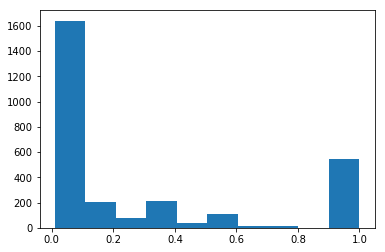

In [165]:
plt.hist([value for filename, value in topics_of_files3])

It seems, that if I put the threshold at 20% or even 10%, I am still not going to eliminate most of the text. It is a very binominal distribution, with most either having almost nothing or almost all of nature topic in text. 

In [184]:
topics_of_files_eliminate = [filename for filename, value in topics_of_files3 if value > 0.00]

In [185]:
len(topics_of_files_eliminate)

2857

Now I am going to copy all the texts in the next folder and then delete the ones, where nature topic is included at all. This will eliminate 2857 texts. 

I am not eliminating just text, where the nature is the strongest topic, because then the nature topic still gets represented in the topics (in some cases with multiple topics). Including the texts, where this topic was represented less than 10% helped, but not eliminated the problem. 

In [190]:
all_files_filtered = os.listdir(folder_filtered)

In [191]:
for filename in all_files_filtered:
    shutil.copyfile(os.path.join(folder_filtered, filename), os.path.join(folder_python, filename))

In [192]:
for filename in topics_of_files_eliminate:
    os.remove(os.path.join(folder_python, filename))

In [193]:
len(os.listdir(folder_python))

5259

And now I am left with 5259 posts. 

## Topic Modeling - Getting Topics

So now we are left with only the topics, that deal with python as a programming. Now the 'real' topic modeling can begin. So now, by using the texts left over, I am going to build topic models with from 2 to 29 topics. 

In [195]:
all_files_python = os.listdir(folder_python)

In [196]:
all_words_python =  []
for filename in all_files_python:
    with open(os.path.join(folder_python, filename), "r") as f:
        words = f.readlines()
        words = [w.strip() for w in words]
    all_words_python.append(words)

In [197]:
dictionary_python = gensim.corpora.Dictionary(all_words_python)

In [198]:
doc_term_matrix_python = [dictionary_python.doc2bow(doc) for doc in all_words_python]

In [199]:
models_python = []

In [200]:
for i in range(2,30):
    print(i)
    name = "LDA_2_" + str(i)
    Lda = gensim.models.ldamodel.LdaModel
    model = Lda(doc_term_matrix_python, num_topics=i, id2word = dictionary_python, passes=20)
    model.save(os.path.join(folder_models_2, name))
    vis = pyLDAvis.gensim.prepare(model, doc_term_matrix_python, dictionary_python)
    with open(os.path.join(folder_vis_2, name), "wb") as f:
        pickle.dump(vis, f)
    pyLDAvis.save_html(vis, os.path.join(folder_vis_2, name + ".html"))
    models_python.append([i, model, vis])

2


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


3


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


4


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


5


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


6


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


7


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


8


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


9


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


10


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


11


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


12


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


13


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


14


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


15


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


16


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


17


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


18


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


19


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


20


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


21


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


22


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


23


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


24


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


25


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


26


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


27


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


28


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


29


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Coherence and perplexity can help with deciding how many topics to choose. With perplexsity is the lower the better, and with coherence it is the higer the better. But they are just rhe guidelines. So here is the way, how to calculate and plot them. 

In [202]:
all_values = []
for _, model_current, _ in models_python:
    m = model_current.log_perplexity(doc_term_matrix_python)
    c = gensim.models.CoherenceModel(model=model_current, texts=all_words_python, dictionary=dictionary_python, coherence='c_v')
    cc = c.get_coherence()
    all_values.append(tuple([model_current.num_topics, m, cc]))

In [211]:
all_values

[(2, -7.147427696331892, 0.4413736983682601),
 (3, -7.080754639097655, 0.4676653082712983),
 (4, -7.050363558275542, 0.46550099002561984),
 (5, -7.0331824229667586, 0.48487537695220506),
 (6, -7.023920456695701, 0.47021956873593007),
 (7, -7.0370474699589405, 0.4550923127852453),
 (8, -7.028582678483683, 0.4681567351521483),
 (9, -7.034688005414624, 0.4612604694137026),
 (10, -7.0267763608315335, 0.4520902678215581),
 (11, -7.022367229819862, 0.4190862638335437),
 (12, -7.020395961822716, 0.47392575096234874),
 (13, -7.025963647754216, 0.4111083897786752),
 (14, -7.021391877326452, 0.4575718911043333),
 (15, -7.025766200003005, 0.40789999609396427),
 (16, -7.016136047263336, 0.41400974181631245),
 (17, -7.025273078678406, 0.456542697146737),
 (18, -7.030333588747908, 0.4180401544510404),
 (19, -7.01779996656294, 0.4288945461831942),
 (20, -7.017802007469783, 0.44597786146151197),
 (21, -7.016891323358987, 0.4118289779436532),
 (22, -7.020193369801725, 0.3970172472908345),
 (23, -7.0232

In [212]:
?plt.plot

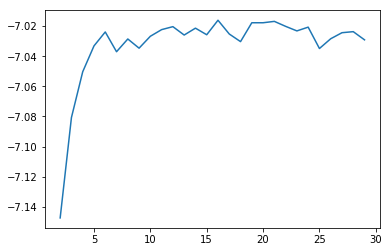

In [214]:
plt.plot([model for model, p, c in all_values], [p for model, p, c in all_values])

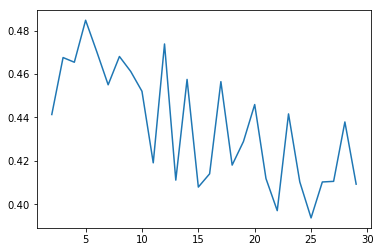

In [215]:
plt.plot([model for model, p, c in all_values], [c for model, p, c in all_values])

## Topic Modling - 5 Topic Solution

First I am going to check, which words are the most representitive of each topic. 

In [222]:
models_python[3][1].print_topics(num_topics=-1, num_words=15)

[(0,
  '0.017*"think" + 0.012*"good" + 0.011*"section" + 0.010*"paper" + 0.009*"way" + 0.009*"text" + 0.008*"question" + 0.008*"grade" + 0.007*"get" + 0.007*"know" + 0.007*"discuss" + 0.007*"read" + 0.007*"point" + 0.006*"want" + 0.006*"make"'),
 (1,
  '0.018*"twilio" + 0.017*"use" + 0.012*"creat" + 0.012*"messag" + 0.010*"user" + 0.009*"need" + 0.009*"code" + 0.009*"call" + 0.008*"instal" + 0.008*"new" + 0.008*"number" + 0.008*"app" + 0.008*"api" + 0.008*"function" + 0.007*"add"'),
 (2,
  '0.039*"python" + 0.019*"use" + 0.013*"program" + 0.012*"code" + 0.012*"link" + 0.010*"learn" + 0.010*"data" + 0.010*"work" + 0.008*"languag" + 0.007*"get" + 0.006*"develop" + 0.006*"time" + 0.006*"want" + 0.006*"comment" + 0.006*"run"'),
 (3,
  '0.014*"startup" + 0.012*"peopl" + 0.010*"work" + 0.009*"get" + 0.009*"make" + 0.008*"compani" + 0.008*"thing" + 0.007*"want" + 0.006*"good" + 0.006*"seem" + 0.006*"way" + 0.006*"start" + 0.006*"think" + 0.006*"idea" + 0.005*"investor"'),
 (4,
  '0.027*"print

Since sometimes topics can be a bit ambiguous, I also like the check the titles of the posts, that are the most representitive of each topic. Here below is how to list the most representitive titles. 

In [280]:
all_files_python = os.listdir(folder_python)

In [281]:
all_posts = os.listdir(folder_posts)

In [282]:
topics_of_files = []
m = models_python[3][1]
model_name = "model_2_5"
for filename in all_files_python:
    text_name = filename
    with open(os.path.join(folder_python, filename)) as f:
        data_file = f.readlines()
    data_file = [w.strip() for w in data_file]
    new_vector = dictionary_python.doc2bow(data_file)
    topics_current = m.get_document_topics(new_vector)
    with open(os.path.join(folder_posts, filename)) as f:
        data = f.readlines()
        data = " ".join(data)
    data = json.loads(data)
    title = data["title"]
    date = data["date"]
    topics_of_files.append(tuple([model_name, text_name, title, date, topics_current]))

In [283]:
topics_of_files_python = [[model, filename, title, date] + [dict(topics)[i] if i in dict(topics) else 0 for i in range(5)] for model, filename, title, date, topics in topics_of_files]

In [284]:
topics_of_files_python = pandas.DataFrame(topics_of_files_python)

In [285]:
topics_of_files_python = topics_of_files_python.set_axis(["model", "file", "title", "date", "0", "1", "2", "3", "4"], axis='columns', inplace=False)

In [551]:
topics_of_files_python.head(0)

,model,file,title,date,0,1,2,3,4,month,year


In [550]:
topics_of_files_python.sort_values(by="4", axis=0, ascending=False).head(0)

,model,file,title,date,0,1,2,3,4,month,year


It is this panda dataframe just up above, that has it sorted by the most represetitive for topic 4. 

Putting all of this information together, I think this are the topics found in the data:

* 0: School
* 1: Making Communication
* 2: Learning Python
* 3: Startup
* 4: Code examples

These can also be ploted in time. I decided to take the year approach. There I need to do some filtering. I need to find out, how many posts were posted by year. 

In [289]:
number_of_python_files = topics_of_files_python.shape[0]

In [290]:
number_of_python_files

5259

In [326]:
years = []
for d in topics_of_files_python["date"]:
    years.append(d[:4])

In [327]:
topics_of_files_python["year"] = years

In [328]:
posts_per_year = collections.defaultdict(int)
for index, row in topics_of_files_python.iterrows():
    posts_per_year[row["year"]] += 1

In [329]:
posts_per_year

defaultdict(int,
            {'2018': 1522,
             '2015': 977,
             '2012': 160,
             '2017': 1139,
             '2014': 523,
             '2019': 574,
             '2016': 290,
             '2013': 56,
             '2010': 5,
             '2009': 6,
             '2011': 2,
             '2008': 2,
             '2006': 2,
             '2007': 1})

After I have the number of posts per year, then I need the representation of topics in post. For each post, the sum of topics is 1, so I can just sum the topic fractions to get the representation in a year in all the posts in the year.

In [331]:
topics_per_year = collections.defaultdict(dict)
for index, row in topics_of_files_python.iterrows():
    current_year = row["year"]
    for i in range(5):
        if i not in topics_per_year[current_year]:
            topics_per_year[current_year][i] = 0
        topics_per_year[current_year][i] += row[str(i)]

I then divide them by number of posts per year to get fraction of posts on that topic. 

In [333]:
topics_per_year_freq = collections.defaultdict(dict)
for year, values in topics_per_year.items():
    posts_in_that_year = posts_per_year[year]
    for topic, count in values.items():
        topics_per_year_freq[year][topic] = count/posts_in_that_year

In [336]:
all_years = sorted(list(topics_per_year_freq.keys()))

In [338]:
all_topic_freq_by_year = []
for i in range(5):
    current_topic_freq = []
    for year in all_years:
        current_topic_freq.append(topics_per_year_freq[year][i])
    all_topic_freq_by_year.append(current_topic_freq)

In [346]:
topic_labels = ["school", "making communication", "learning python", "startup", "code examples"]

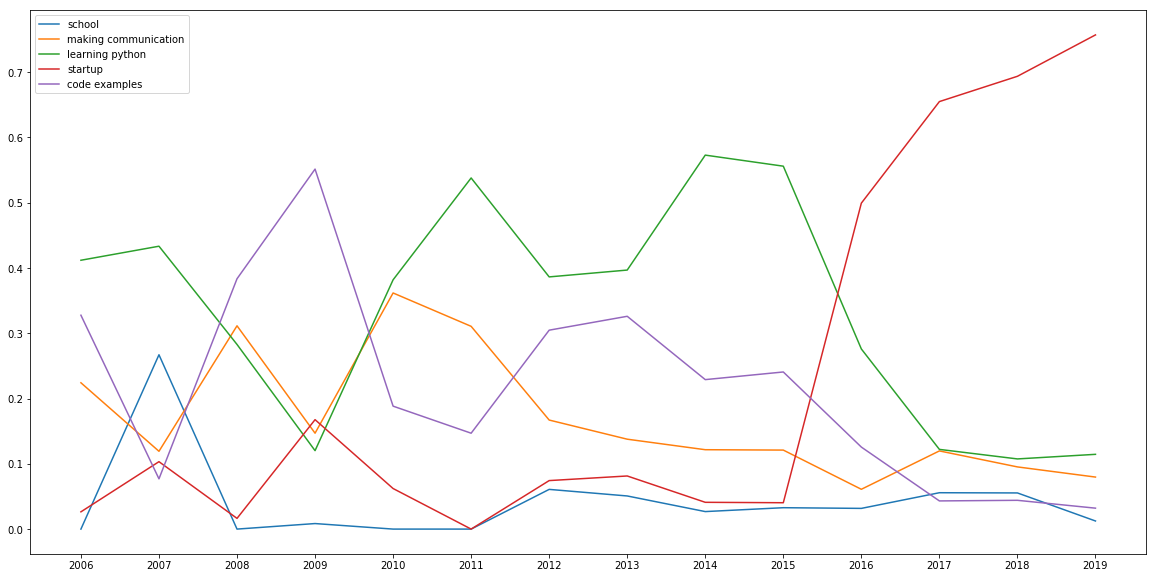

In [347]:
plt.figure(figsize=(20,10))
for l, t in zip(topic_labels, all_topic_freq_by_year):
    plt.plot(all_years, t, label=l)
plt.legend(loc='best')

Going be this post, learning python seemsto be the most popular one through the yearsm except the most recent ones, when it got overturned by startup topic.

Since there are not a lot of python posts in the early years, the data can be a bit misleading in these years. So I decided to also plot the absolute values for all the years except the 2019 (so current). 

In [354]:
topics_per_year_for_plot = []
for i in range(5):
    current_topic_freq = []
    for year in all_years:
        if year != "2019":
            current_topic_freq.append(topics_per_year[year][i])
    topics_per_year_for_plot.append(current_topic_freq)

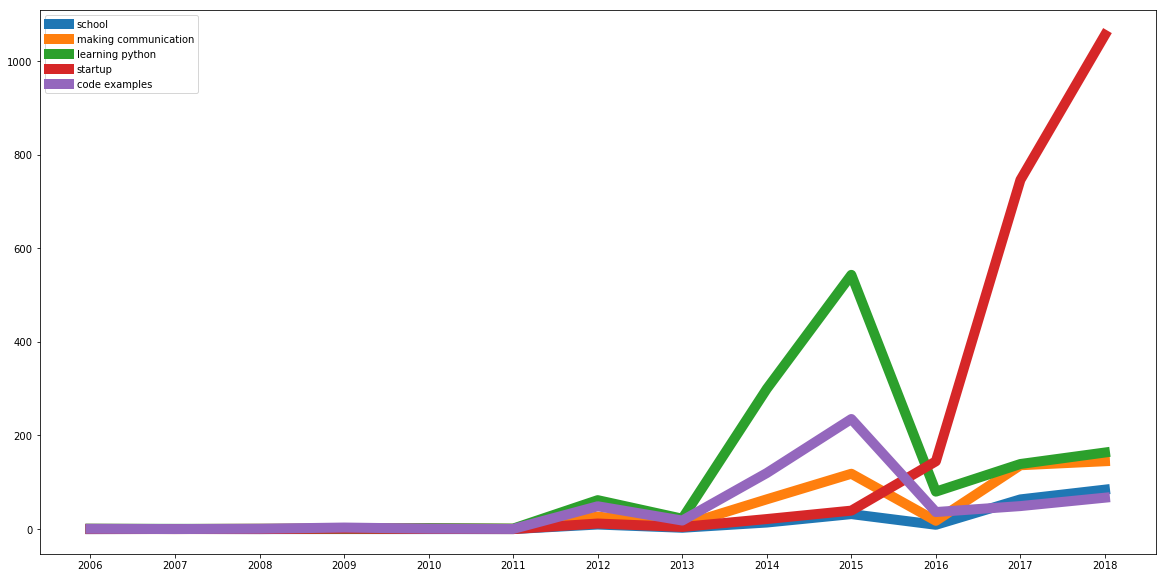

In [357]:
plt.figure(figsize=(20,10))
for l, t in zip(topic_labels, topics_per_year_for_plot):
    plt.plot(all_years[:-1], t, label=l, linewidth=10)
plt.legend(loc='best')

Here one ca see, that there was a interests in coding (or more interest in Tumblr) starting in 2013. This can be seen in the hill of topic learing python and code examples. But since 2016, it is the startup scene, that gets the most quickest growth.

## Topic Modeling - 17 Topic Solution

Now I am also going to check the 17 topic solution. Here below are the most representitive words.

In [359]:
models_python[15][1].print_topics(num_topics=-1, num_words=15)

[(0,
  '0.017*"think" + 0.013*"good" + 0.012*"section" + 0.011*"paper" + 0.009*"way" + 0.009*"grade" + 0.008*"question" + 0.008*"text" + 0.007*"get" + 0.007*"discuss" + 0.007*"read" + 0.007*"point" + 0.007*"want" + 0.006*"make" + 0.006*"know"'),
 (1,
  '0.051*"def" + 0.046*"return" + 0.046*"print" + 0.037*"import" + 0.027*"self" + 0.023*"class" + 0.022*"python" + 0.016*"object" + 0.014*"name" + 0.012*"true" + 0.011*"els" + 0.010*"valu" + 0.010*"len" + 0.010*"fals" + 0.009*"type"'),
 (2,
  '0.038*"instal" + 0.035*"file" + 0.029*"python" + 0.024*"use" + 0.022*"run" + 0.018*"script" + 0.013*"command" + 0.012*"http" + 0.012*"packag" + 0.010*"work" + 0.009*"server" + 0.009*"pip" + 0.009*"need" + 0.009*"modul" + 0.009*"line"'),
 (3,
  '0.038*"commun" + 0.018*"messag" + 0.018*"organ" + 0.015*"help" + 0.014*"social" + 0.014*"twilio" + 0.014*"support" + 0.013*"peopl" + 0.011*"impact" + 0.011*"vote" + 0.010*"provid" + 0.009*"campaign" + 0.009*"develop" + 0.008*"access" + 0.008*"text"'),
 (4,
  '

These are the topics, that I think exist here:
    
* 0: School
* 1: Code examples (in foreign langauge)
* 2: Installing
* 3: Communication
* 4: Questions and Answers
* 5: Working in Startups
* 6: Creating Apps
* 7: Learning Python
* 8: Creating Startups
* 9: Programming
* 10: Y-Combinator
* 11: Autentication
* 12: Code examples
* 13: Data Analysis
* 14: Lessons from Startup World
* 15: Announcments
* 16: Python Courses

Since I had some problems with defining some topics, I again created myself some help with looking at the titles of most prepresetitive posts.

In [362]:
all_files_python = os.listdir(folder_python)

In [363]:
all_posts = os.listdir(folder_posts)

In [364]:
topics_of_files_17 = []
m = models_python[15][1]
model_name = "model_2_17"
for filename in all_files_python:
    text_name = filename
    with open(os.path.join(folder_python, filename)) as f:
        data_file = f.readlines()
    data_file = [w.strip() for w in data_file]
    new_vector = dictionary_python.doc2bow(data_file)
    topics_current = m.get_document_topics(new_vector)
    with open(os.path.join(folder_posts, filename)) as f:
        data = f.readlines()
        data = " ".join(data)
    data = json.loads(data)
    title = data["title"]
    date = data["date"]
    topics_of_files_17.append(tuple([model_name, text_name, title, date, topics_current]))

In [374]:
topics_of_files_python_17 = [[dict(topics)[i] if i in dict(topics) else 0 for i in range(17)] + [title] for model, filename, title, date, topics in topics_of_files_17]

In [375]:
topics_of_files_python_17 = pandas.DataFrame(topics_of_files_python_17 )

In [549]:
list(topics_of_files_python_17.sort_values(by=1, axis=0, ascending=False).head(0)[17])

[]

Now let us go through the topics and see, which ones tend to appear together. 

First we need to figure out, how many posts are there.

In [408]:
number_of_python_files_17 = topics_of_files_python_17.shape[0]

In [409]:
number_of_python_files_17

5259

There are 5259 files. 

Next, I am going to get how many posts have each topic.

In [413]:
file_number_by_topic_17 = dict()
for i in range(17):
    file_number_by_topic_17[i] = len([n for n in topics_of_files_python_17[i] if n != 0])

In [414]:
file_number_by_topic_17

{0: 775,
 1: 995,
 2: 1318,
 3: 443,
 4: 715,
 5: 1977,
 6: 992,
 7: 1827,
 8: 2420,
 9: 465,
 10: 1204,
 11: 565,
 12: 1384,
 13: 891,
 14: 2549,
 15: 1010,
 16: 1434}

And now I am going to calculate, how many times the topics appear in the same post. 

In [415]:
topic_connections = collections.defaultdict(dict)
for index, row in topics_of_files_python_17.iterrows():
    topics_in_row = []
    for i in range(17):
        current_value = row[i]
        if current_value != 0:
            topics_in_row.append(i)
    for i in topics_in_row:
        for j in topics_in_row:
            if i > j:
                if not j in topic_connections[i]:
                    topic_connections[i][j] = 0
                topic_connections[i][j] += 1

And now I am going to use the graph to try and see, if there is any connection, that are more frequent, then it would be expected just based on their frequency in text. 

In [482]:
A=networkx.Graph()

In [483]:
for topic1, data in topic_connections.items():
    for topic2, count in data.items():
        freq_con = count / number_of_python_files_17
        freq_expect = (file_number_by_topic_17[topic1]/number_of_python_files_17) * (file_number_by_topic_17[topic2]/number_of_python_files_17)
        surprise = freq_con - freq_expect
        if surprise > 0.01:
            A.add_edge(topic1,topic2)

In [485]:
A.nodes()

NodeView((8, 5, 10, 14, 4, 0, 11, 1, 2, 6, 7, 12, 16, 13, 15, 3))

In [486]:
mapping_python_topics = {0: "School", 1: "Code Examples (foreign)", 2: "Installing", 3: "Communication", 4: "Q and A", 
                         5: "Working in Startups", 6: "Creating Apps", 7: "Learning Python", 8: "Creating Startups", 
                         9: "Programming", 10: "Y-Combinator", 11: "Autentication", 12: "Code Examples", 
                         13: "Data Analysis", 14: "Startup Lessons", 15: "Announcments", 16: "Python Courses"}

In [487]:
A=networkx.relabel_nodes(A,mapping_python_topics)

In [488]:
A.nodes()

NodeView(('Creating Startups', 'Working in Startups', 'Y-Combinator', 'Startup Lessons', 'Q and A', 'School', 'Autentication', 'Code Examples (foreign)', 'Installing', 'Creating Apps', 'Learning Python', 'Code Examples', 'Python Courses', 'Data Analysis', 'Announcments', 'Communication'))

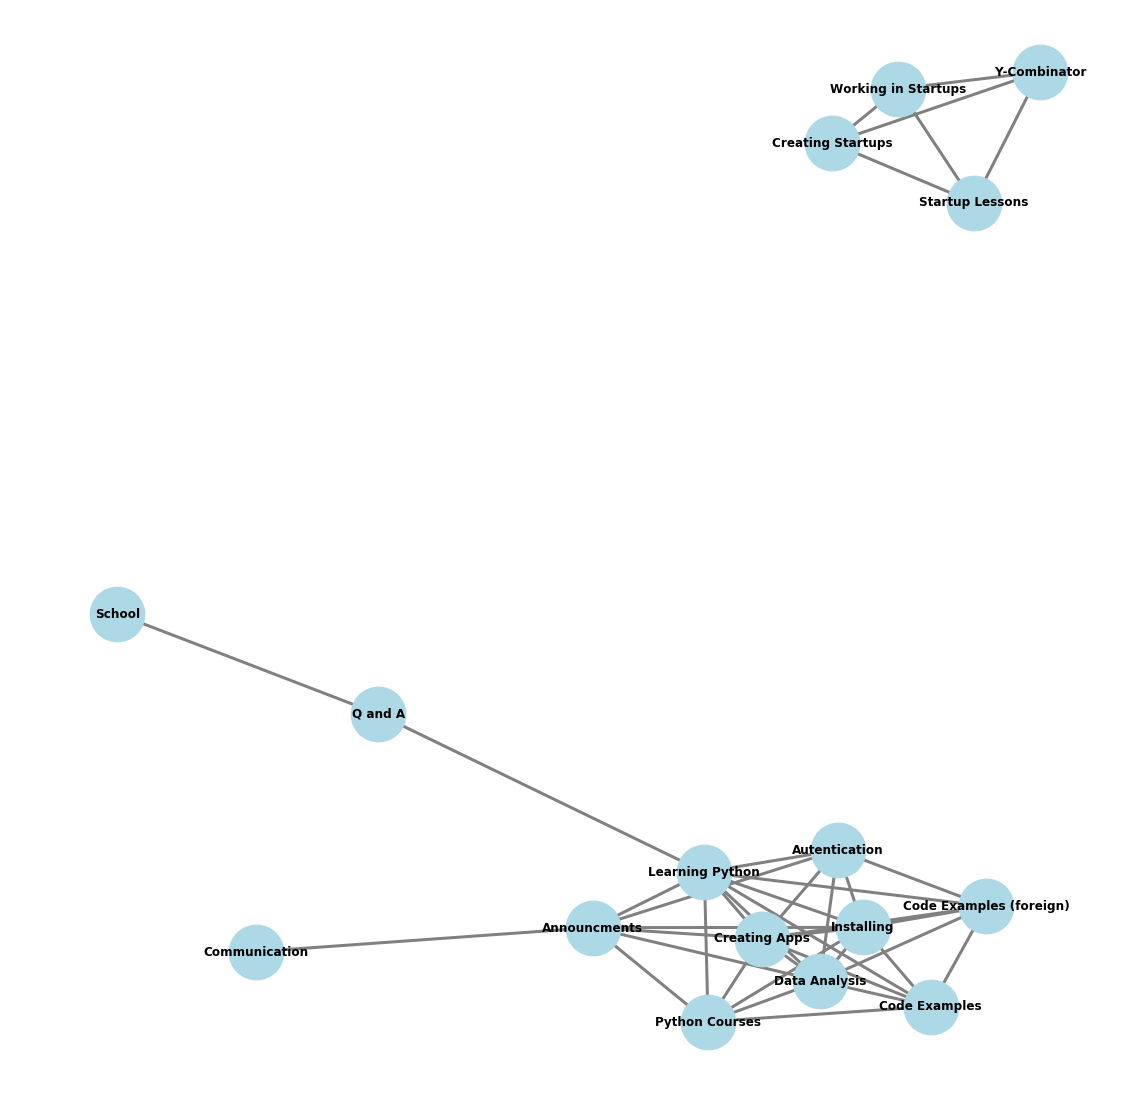

In [496]:
plt.figure(1,figsize=(15,15)) 
networkx.draw(A, 
        with_labels=True, 
        pos=networkx.spring_layout(A, k=0.5), 
        font_weight='bold', 
        node_color="lightblue",
        edge_color="gray",
        width=3, 
        arrows=True, 
        node_size=3000,
             )

We can see, that there is two groups of topics. One is about the startups, and the other is about coding. The topic programming (which is a general topic abour programming in different langauges) is not connected more than expected with any oter topic.

## Topic Modeling - Getting just Python (without Startup)

For the next one, I am going to remove all the posts, that have a startup stuff in them. So I am going to copy the files in a new folder and deleted all that have startup topic in them. For this, I am going to be using the 2-topic solution and deleted every post, that have some startup in them. 

Below is the two-topic solution with topic 0 as coding and topic 2 as startup.

In [500]:
models_python[0][1].print_topics(num_topics=-1, num_words=15)

[(0,
  '0.014*"python" + 0.014*"use" + 0.008*"code" + 0.007*"twilio" + 0.006*"number" + 0.006*"creat" + 0.006*"need" + 0.006*"file" + 0.006*"get" + 0.006*"data" + 0.006*"function" + 0.006*"import" + 0.005*"return" + 0.005*"call" + 0.005*"make"'),
 (1,
  '0.013*"startup" + 0.012*"peopl" + 0.010*"work" + 0.009*"get" + 0.009*"make" + 0.008*"thing" + 0.008*"compani" + 0.007*"good" + 0.007*"want" + 0.006*"think" + 0.006*"way" + 0.006*"seem" + 0.006*"idea" + 0.006*"start" + 0.005*"someth"')]

Now I am going to calculate the topics of each of the post.

In [501]:
topics_of_files_2 = []
m = models_python[0][1]
model_name = "model_2_2"
for filename in all_files_python:
    text_name = filename
    with open(os.path.join(folder_python, filename)) as f:
        data_file = f.readlines()
    data_file = [w.strip() for w in data_file]
    new_vector = dictionary_python.doc2bow(data_file)
    topics_current = m.get_document_topics(new_vector)
    topics_of_files_2.append(tuple([text_name, topics_current]))

In [503]:
len(topics_of_files_2)

5259

In [504]:
topic_of_files_2_startup = [filename for filename, topics in topics_of_files_2 if 1 in dict(topics)]

In [505]:
len(topic_of_files_2_startup)

4809

There are 5259 posts overall, and 4809 include the startup topic. And these are the ones, that I am going to delete.

In [507]:
for filename in all_files_python:
    shutil.copyfile(os.path.join(folder_python, filename), os.path.join(folder_coding, filename))

In [508]:
for filename in topic_of_files_2_startup:
    os.remove(os.path.join(folder_coding, filename))

In [509]:
len(os.listdir(folder_coding))

450

So now I am left with 450 posts, that are strictly about python coding. Now I am going to create topic models from just these posts. 

In [510]:
all_files_coding = os.listdir(folder_coding)

In [511]:
all_words_coding =  []
for filename in all_files_coding:
    with open(os.path.join(folder_coding, filename), "r") as f:
        words = f.readlines()
        words = [w.strip() for w in words]
    all_words_coding.append(words)

In [512]:
dictionary_coding = gensim.corpora.Dictionary(all_words_coding)
doc_term_matrix_coding = [dictionary_coding.doc2bow(doc) for doc in all_words_coding]

In [514]:
models_coding = []

In [515]:
for i in range(2,10):
    print(i)
    name = "LDA_3_" + str(i)
    Lda = gensim.models.ldamodel.LdaModel
    model = Lda(doc_term_matrix_coding, num_topics=i, id2word = dictionary_coding, passes=20)
    model.save(os.path.join(folder_models_3, name))
    vis = pyLDAvis.gensim.prepare(model, doc_term_matrix_coding, dictionary_coding)
    with open(os.path.join(folder_vis_3, name), "wb") as f:
        pickle.dump(vis, f)
    pyLDAvis.save_html(vis, os.path.join(folder_vis_3, name + ".html"))
    models_coding.append([i, model, vis])

2


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


3


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


4


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


5


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


6


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


7


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


8


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


9


/usr/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Now if we look at the 5-topic solution, these are the topics that came out of it.

In [518]:
models_coding[3][1].print_topics(num_topics=-1, num_words=15)

[(0,
  '0.017*"use" + 0.015*"user" + 0.014*"creat" + 0.013*"file" + 0.012*"code" + 0.011*"function" + 0.011*"video" + 0.010*"follow" + 0.009*"new" + 0.009*"room" + 0.009*"return" + 0.009*"app" + 0.009*"add" + 0.009*"import" + 0.008*"applic"'),
 (1,
  '0.025*"messag" + 0.021*"chat" + 0.020*"compon" + 0.018*"channel" + 0.015*"function" + 0.015*"return" + 0.013*"que" + 0.013*"creat" + 0.011*"add" + 0.011*"applic" + 0.011*"token" + 0.010*"app" + 0.010*"set" + 0.010*"import" + 0.009*"null"'),
 (2,
  '0.047*"def" + 0.043*"print" + 0.033*"return" + 0.030*"import" + 0.027*"self" + 0.021*"python" + 0.011*"name" + 0.009*"class" + 0.009*"len" + 0.009*"true" + 0.009*"valu" + 0.008*"els" + 0.008*"object" + 0.008*"code" + 0.007*"list"'),
 (3,
  '0.024*"twilio" + 0.019*"use" + 0.018*"number" + 0.017*"messag" + 0.014*"creat" + 0.012*"call" + 0.011*"function" + 0.010*"code" + 0.010*"need" + 0.010*"phone" + 0.010*"send" + 0.009*"new" + 0.008*"app" + 0.008*"api" + 0.008*"let"'),
 (4,
  '0.033*"python" + 

The topics are:

* 0: Creating video apps
* 1: Extending websites
* 2: Code examples
* 3: Creating chat apps
* 4: Setting up programs

Since I needed some help understanding them, here is again the code to see the titles of most representative posts.

In [532]:
topics_of_files_3 = []
m = models_coding[3][1]
model_name = "model_3_5"
for filename in all_files_coding:
    text_name = filename
    with open(os.path.join(folder_coding, filename)) as f:
        data_file = f.readlines()
    data_file = [w.strip() for w in data_file]
    new_vector = dictionary_coding.doc2bow(data_file)
    topics_current = m.get_document_topics(new_vector)
    with open(os.path.join(folder_posts, filename)) as f:
        data = f.readlines()
        data = " ".join(data)
    data = json.loads(data)
    title = data["title"]
    topics_of_files_3.append(tuple([text_name, title, topics_current]))

In [536]:
topic_of_files_3_topics = [[dict(topics)[i] if i in dict(topics) else 0 for i in range(5)] + [title] for filename, title, topics in topics_of_files_3]

In [537]:
topic_of_files_3_topics = pandas.DataFrame(topic_of_files_3_topics)

In [548]:
topic_of_files_3_topics.sort_values(by=1, axis=0, ascending=False).head(0)

,0,1,2,3,4,5
